In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from pathlib import Path
from spyrit.misc.statistics import stat_walsh_stl10
from spyrit.misc.statistics import *
from spyrit.misc.disp import *
from spyrit.misc.matrix_tools import *
from spyrit.core.Preprocess import *
from spyrit.core.Forward_Operator import *

In [2]:
img_size = 64 # image size
M = 1024    # number of measurements
alpha = 50     # Image intensity (in photons)
bs = 10 # Batch size

#- Model and data paths
data_root = Path('../../data/')
stats_root = Path('../../data/stats_walsh')

In [3]:
#%% A batch of STL-10 test images
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

testset = \
    torchvision.datasets.STL10(root=data_root, split='test',download=False, transform=transform)
testloader =  torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False)

In [4]:
inputs, _ = next(iter(testloader))
b,c,h,w = inputs.shape

In [5]:
# stat_walsh_stl10()
Cov = np.load(stats_root / Path("Cov_{}x{}.npy".format(img_size, img_size)))
Mean = np.load(stats_root / Path("Average_{}x{}.npy".format(img_size, img_size)))
H =  wh.walsh2_matrix(img_size)
# H =  wh.walsh2_matrix(img_size)/img_size


Ord = Cov2Var(Cov)
Perm = Permutation_Matrix(Ord)
Pmat = np.dot(Perm,H);
Pmat = Pmat[:M,:];

In [6]:
x = inputs.view(b*c,w*h)

x = torch.tensor(np.random.random([batch_size,img_size]), dtype=torch.float)## Instantiate Forward Operators

In [7]:
FO = Forward_operator(Pmat)
FO_Split = Forward_operator_Split(Pmat)

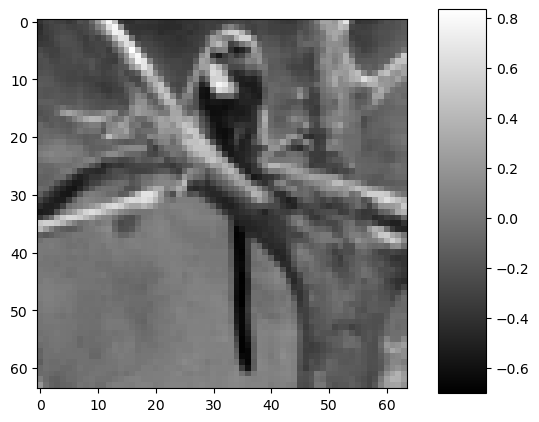

In [8]:
img = x[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

# Split_diag_poisson_preprocess

In [9]:
SPP = Preprocess_Split_diag_poisson_preprocess(alpha, M, w*h)

## forward

In [10]:
y_FO_Split = FO_Split(x)
y = SPP(y_FO_Split,FO_Split)

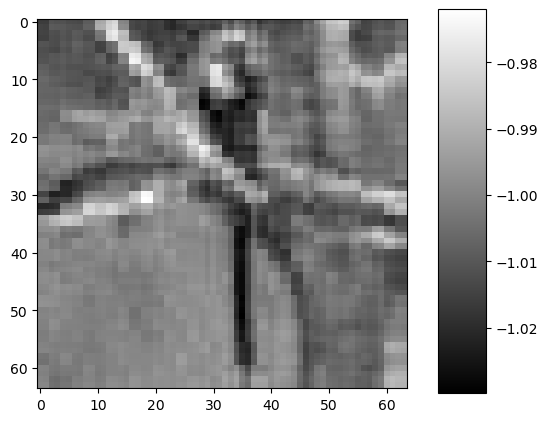

In [11]:
x_est = FO_Split.adjoint(y)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

## sigma

In [12]:
y_sigma = SPP.sigma(y_FO_Split)

TO DO :
* Vérifier que sigma est proche de $(H_+*f+H_-*f)*/N0^2$ (voir m = FO_split((x+1)/2) dand forward operator debug)
    

http://wiki.stat.ucla.edu/socr/index.php/AP_Statistics_Curriculum_2007_Limits_Norm2Poisson

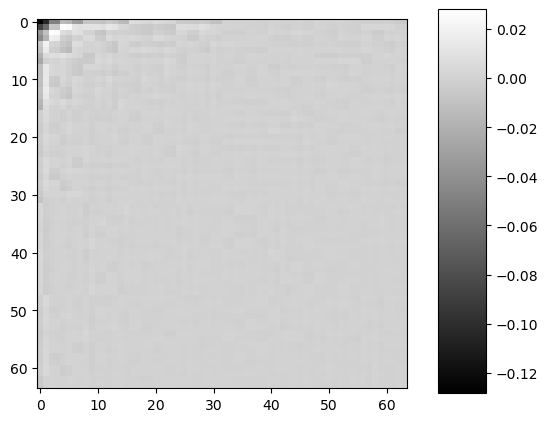

In [13]:
x_est = FO_Split.adjoint(y_sigma)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

## sigma_expe

In [14]:
y_sigma_expe = SPP.sigma_expe(x, gain=1, mudark=0, sigdark=0, nbin=1)

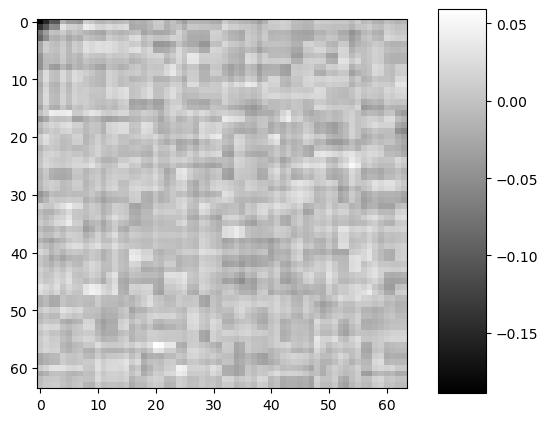

In [15]:
x_est = FO_Split.adjoint(y_sigma_expe)
img = 1/(w*h)*x_est[1,:]
img = img.numpy();
imagesc(np.reshape(img,(h,w)))

## sigma_from_image

In [16]:
y_FO = FO(x)
y_sigma_from_image = SPP.sigma_from_image(y_FO, FO)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x1024 and 4096x1024)